In [1]:
install.packages("caret")

also installing the dependencies 'pillar', 'glue', 'tibble', 'ellipsis', 'dplyr', 'vctrs', 'cpp11', 'generics', 'lifecycle', 'rlang', 'tidyr', 'tidyselect', 'ModelMetrics', 'recipes', 'pROC'



package 'pillar' successfully unpacked and MD5 sums checked
package 'glue' successfully unpacked and MD5 sums checked
package 'tibble' successfully unpacked and MD5 sums checked
package 'ellipsis' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked
package 'vctrs' successfully unpacked and MD5 sums checked
package 'cpp11' successfully unpacked and MD5 sums checked
package 'generics' successfully unpacked and MD5 sums checked
package 'lifecycle' successfully unpacked and MD5 sums checked
package 'rlang' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked
package 'tidyselect' successfully unpacked and MD5 sums checked
package 'ModelMetrics' successfully unpacked and MD5 sums checked
package 'recipes' successfully unpacked and MD5 sums checked
package 'pROC' successfully unpacked and MD5 sums checked
package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages 

In [1]:
library(caret)
library(keras)
use_condaenv("r-tensorflow")
#library(randomForest)
#library(tidymodels)
#library(keras)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [19]:
train <- read.csv(file = '../../Data/training_data.csv')
library(keras)
dim(train)
train <- train[,-3]
X <- train[,-2]
X$Intensity <- as.numeric(X$Intensity)
X <- as.matrix(X)
Y <- train[,2]
dim(X)

[1]  708 4872

[1]  708 4870

In [41]:
install.packages("MASS")

package 'MASS' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'MASS'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\cpien\anaconda3\envs\bio322\Lib\R\library\00LOCK\MASS\libs\x64\MASS.dll vers C:\Users\cpien\anaconda3\envs\bio322\Lib\R\library\MASS\libs\x64\MASS.dll: Permission denied"Warning message:
"restored 'MASS'"


The downloaded binary packages are in
	C:\Users\cpien\AppData\Local\Temp\RtmpSSaUg0\downloaded_packages


In [42]:
ZeroVar <- function(data) {
   out <- lapply(data, function(x) length(unique(x)))
   want <- which(!out > 1)
   unlist(want)
}

In [3]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
Y <- train$VALENCE.PLEASANTNESS
train <- subset(train,select = -VALENCE.PLEASANTNESS)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.7))
data.unC <- train.Z[,-id]
X <- as.matrix(data.unC)

In [13]:
dim(X)

[1] 708 196

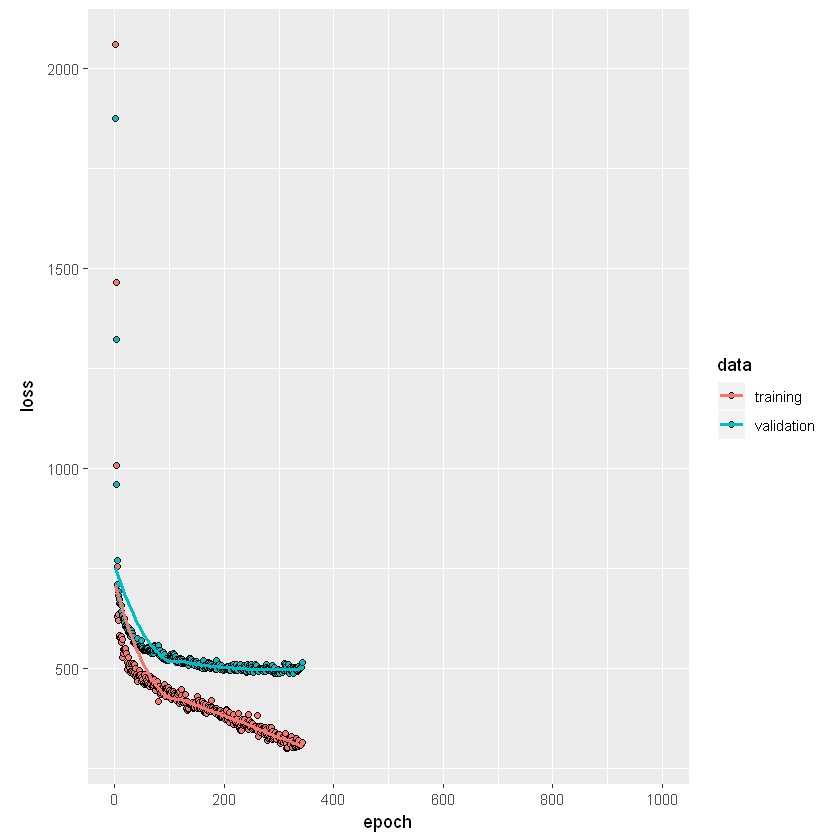

In [9]:
nn <- keras_model_sequential()

nn %>%
 layer_dense(units = 20,  activation = 'relu', kernel_initializer = "he_normal", input_shape = 196)  %>%
 layer_dropout(0.05) %>%
 layer_dense(units = 1,activation = 'linear')

nn %>% compile(
  loss = 'mse',
  optimizer = 'adam'
)

history <- nn %>% fit(
  (X), Y, 
  epochs = 1000,
  validation_split = 0.5,
  callbacks = callback_early_stopping(monitor = "val_loss", patience = 50)
)
plot(history)

In [13]:
library(caret)
library(keras)
use_condaenv("r-tensorflow")

In [14]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
#Y <- train$VALENCE.PLEASANTNESS
#train <- subset(train,select = -VALENCE.PLEASANTNESS)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.5))
data.unC <- train.Z[,-id]

idx.train <- sample(nrow(data.unC), nrow(data.unC)*0.5)
Y <- train[idx.train,]$VALENCE.PLEASANTNESS
Y_test <- train[-idx.train,]$VALENCE.PLEASANTNESS
data.unC <- subset(data.unC,select = -VALENCE.PLEASANTNESS)
Xi <- data.unC[idx.train,]
X <- as.matrix(Xi)
X_test <- data.unC[-idx.train,]
X_test <- as.matrix(X_test)
dim(X)[2]

[1] 66

In [15]:
test <- read.csv(file = '../../Data/test_data.csv')
test <- na.omit(test)
test <- test[,-1]
test$Intensity <- as.numeric(test$Intensity)
test <- test[,names(Xi)]
x.testa <- as.matrix(test)

In [16]:
library(MASS)
getdata <- function (seed = 1) {
    set.seed(seed)
    list(train = train,
         boston.test = Y_test,
         boston.train.x = X,
         boston.test.x = X_test
    )
}

In [17]:
library(ggfortify)
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
boston.x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
boston.y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
boston.y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}
keras.func <- function (seed = 1) {
    with(getdata(seed), {
        boston.train.x.prep <- scale(boston.train.x, center = T, scale = T)
        boston.train.y.prep <- scale(Y, center = T, scale = T)
        nn <- keras_model_sequential()
        nn <- nn %>%
            layer_dense(40,kernel_regularizer = regularizer_l2(l = 0.1), activation = "relu", input_shape = c(dim(X)[2])) %>%
            layer_dropout(rate = .6) %>%
            layer_dense(40, kernel_regularizer = regularizer_l2(l = 0.1), activation = "relu") %>%
            layer_dropout(rate = .6) %>%
            layer_dense(1, activation = "linear")
        nn %>% compile(optimizer = "adam", loss = "mean_squared_error")
        history <- nn %>% fit(boston.train.x.prep,
                             boston.train.y.prep,
                             verbose = 2,
                             batch_size = length(boston.train.y.prep),
                             validation_data = list(boston.x.scale(boston.test.x, boston.train.x.prep),
                                                    boston.y.scale(boston.test, boston.train.y.prep)),
                             epochs = 700,
                             callbacks = callback_early_stopping(monitor = "val_loss", patience = 15)
)
     
        nn.pred <- predict(nn, boston.x.scale(boston.test.x, boston.train.x.prep))
        sqrt(mean((boston.y.unscale(nn.pred, boston.train.y.prep) - boston.test)^2))
        
        #results <- predict(nn, boston.x.scale(x.testa, boston.train.x.prep))
        #results <- boston.y.unscale(results,boston.train.y.prep)
        #id <- 1:68
        #temps <- data.frame(results)
        #final.data <- data.frame(Id = id, VALENCE.PLEASANTNESS = temps$results)
        #write_csv(final.data, "../../Submission/NNopti.csv", row.names=FALSE)
        
   })
}

In [18]:
keras.res <- sapply(1:5, keras.func)
keras.res
mean(keras.res)
sqrt(var(keras.res))

[1] 21.64705 21.59216 21.55456 21.51632 21.73675

[1] 21.60937

[1] 0.08602778

In [12]:
keras.func(1)

[1] 22.6635

In [33]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.5))
data.unC <- train.Z[,-id]

idx.train <- sample(nrow(data.unC), nrow(data.unC)*0.6)
Y <- train[idx.train,]$VALENCE.PLEASANTNESS
y.valid <- train[-idx.train,]$VALENCE.PLEASANTNESS
data.unC <- subset(data.unC,select = -VALENCE.PLEASANTNESS)
X <- data.unC[idx.train,]
X <- as.matrix(X)
x.valid <- data.unC[-idx.train,]
x.valid <- as.matrix(X_test)
dim(X)[2]

[1] 66

In [34]:
library(ggfortify)
get.scale <- function(scaled) {
    if ("scaled:center" %in% names(attributes(scaled))) {
        center <- attr(scaled, "scaled:center")
    } else {
        center <- rep(0, ncol(scaled))
    }
    if ("scaled:scale" %in% names(attributes(scaled))) {
        list(center, attr(scaled, "scaled:scale"))
    } else {
        list(center, rep(1., length(center)))
    }
}
x.scale <- function(x, scaled) {
    s <- get.scale(scaled)
    centered <- sweep(x, 2, s[[1]])
    sweep(centered, 2, s[[2]], FUN = "/")
}
y.scale <- function(y, scaled) {
    s <- get.scale(scaled)
    (y - s[[1]])/s[[2]]
}
y.unscale <- function(y, scaled) {
    s <- get.scale(scaled)
    y * s[[2]] + s[[1]]
}

In [36]:
x.scaled <- scale(X,center = T, scale = T)
y.scaled <- scale(Y,center = T, scale = T)
x.valid.scaled <- x.scale(x.valid,x.scaled)
y.valid.scaled <- y.scale(y.valid,y.scaled)

nn <- keras_model_sequential()

nn %>%
 layer_dense(40,kernel_regularizer = regularizer_l2(l = 0.1), activation = "relu", input_shape = c(dim(X)[2])) %>%
 layer_dropout(rate = .6) %>%
 layer_dense(40, kernel_regularizer = regularizer_l2(l = 0.1), activation = "relu") %>%
 layer_dropout(rate = .6) %>%
 layer_dense(1, activation = "linear")

nn %>% compile(
  loss = 'mse',
  optimizer = 'adam'
)

history <- nn %>% fit(
  (x.scaled), y.scaled, 
  epochs = 1000,
  validation_split = 0.5,
  callbacks = callback_early_stopping(monitor = "val_loss", patience = 50)
)

nn.pred <- predict(nn, x.valid.scaled)
sqrt(mean((y.unscale(nn.pred, y.scaled) - y.valid)^2))

Warning message in y.unscale(nn.pred, y.scaled) - y.valid:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"

[1] 24.29885

In [8]:
install.packages("ggfortify")

also installing the dependency 'gridExtra'



package 'gridExtra' successfully unpacked and MD5 sums checked
package 'ggfortify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cpien\AppData\Local\Temp\RtmpS0dRYh\downloaded_packages


In [16]:
train <- read.csv(file = '../../Data/training_data.csv')
train <- subset(train,select = -SWEETORSOUR)
train$Intensity <- as.numeric(train$Intensity)
#Y <- train$VALENCE.PLEASANTNESS
#train <- subset(train,select = -VALENCE.PLEASANTNESS)
train.Z <- subset(train,select = -nearZeroVar(train))
correlation <- cor(train.Z)
id <- sort(findCorrelation(correlation, cutoff=0.5))
data.unC <- train.Z[,-id]

idx.train <- sample(nrow(data.unC), nrow(data.unC)*3/4)
Y <- train[idx.train,]$VALENCE.PLEASANTNESS
Y_test <- train[-idx.train,]$VALENCE.PLEASANTNESS
data.unC <- subset(data.unC,select = -VALENCE.PLEASANTNESS)
X <- data.unC[idx.train,]
X <- as.matrix(X)
X_test <- data.unC[-idx.train,]
X_test <- as.matrix(X_test)

In [17]:
dim(X)
dim(X_test)


[1] 531  66

[1] 177  66

In [21]:
FLAGS <- flags(
  flag_numeric('dropout1', 0.3),
  flag_integer('neurons1', 128),
  flag_integer('neurons2', 128),
  flag_integer('neurons3', 128),
  flag_numeric('l2', 0.001),
  flag_numeric('lr', 0.001)
)
build_model <- function() {
  model <- keras_model_sequential() 
  model %>% 
    layer_dense(units = FLAGS$neurons1, 
                input_shape = 66,
                activation = 'relu',
                kernel_regularizer = regularizer_l2(l = FLAGS$l2)) %>%
    layer_dense(units = FLAGS$neurons2,
                activation = 'relu') %>%
    layer_dropout(FLAGS$dropout1) %>%
    layer_dense(units = FLAGS$neurons3,
                activation = 'relu') %>%
    layer_dense(units = 1)
  
  model %>% compile(
    loss = "mse",
    optimizer = optimizer_rmsprop(lr = FLAGS$lr),
    metrics = list('mean_squared_error')
  )
  model
}


model <- build_model()

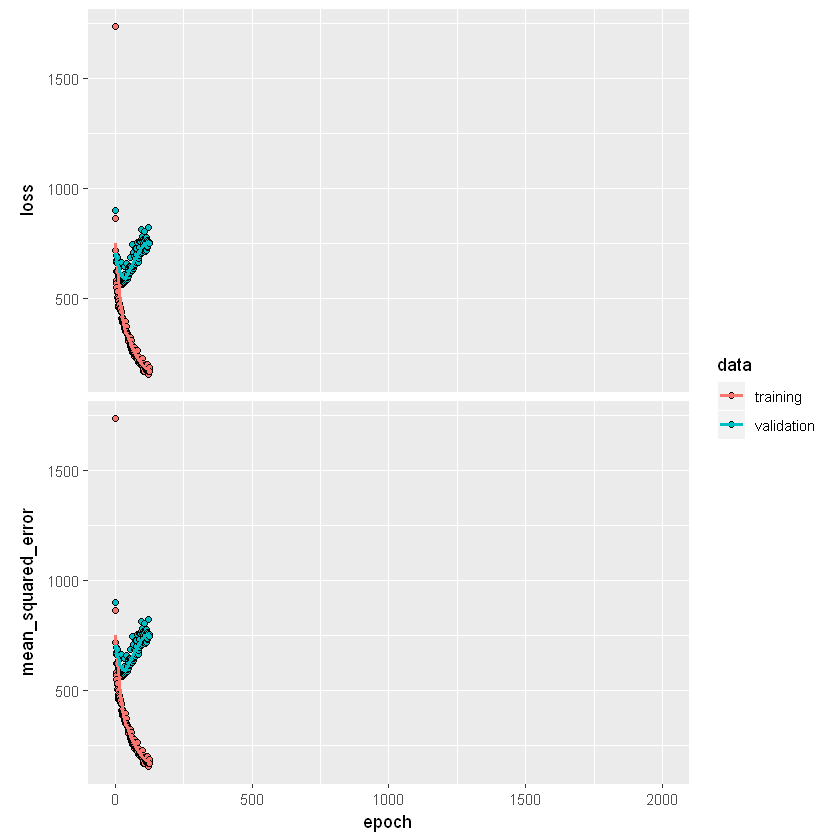

In [22]:
early_stop <- callback_early_stopping(monitor = "val_loss", patience = 100)

epochs <- 2000

# Fit the model and store training stats
history <- model %>% fit(
  (X), Y,
  epochs = epochs,
  validation_split = 0.4,
  verbose = 1,
  callbacks = list(early_stop)
)

plot(history)


In [23]:
score <- model %>% evaluate(
  X_test, Y_test,
  verbose = 0
)

save_model_hdf5(model, 'model.h5')

cat('Test loss:', score$loss, '\n')
cat('Test accuracy:', score$mean_squared_error, '\n')

Test loss: 891.8521 
Test accuracy: 891.7021 


In [1]:
devtools::install_github('henry090/kerastuneR')

ERROR: Error in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]): there is no package called 'rlang'


In [3]:
install.packages("rlang")

package 'rlang' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cpien\AppData\Local\Temp\RtmpSKux6k\downloaded_packages


In [ ]:
install.packages("reticulate")

In [4]:
library(kerastuneR)
par <- list(
  dropout1 = c(0.3,0.4,0.5,0.6),
  neurons1 = c(64,128,256),
  neurons2 = c(64,128,256),
  neurons3 = c(64,128,256),
  l2 = c(0.0001,0.001,0.01),
  lr = c(0.00001,0.0001,0.001,0.01)
)

runs <- tuning_run('nn_ht.R', runs_dir = '_tuning', sample = 0.1, flags = par)

ls_runs(order = metric_val_mean_absolute_error, decreasing= F, runs_dir = '_tuning')

Warning message:
"package 'kerastuneR' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'kerastuneR':
 object 'PyClass' is not exported by 'namespace:reticulate'


In [ ]:
best_run <- ls_runs(order = metric_val_mean_absolute_error, decreasing= F, runs_dir = '_tuning')[1,]

run <- training_run('nn_ht.R',flags = list(
  dropout1 = best_run$flag_dropout1,
  neurons1 = best_run$flag_neurons1,
  neurons2 = best_run$flag_neurons2,
  neurons3 = best_run$flag_neurons3,
  l2 = best_run$flag_l2,
  lr = best_run$flag_lr))

best_model <- load_model_hdf5('model.h5')

## Nathan tests


In [1]:
nn <- keras_model_sequential()
nn %>%
  layer_dense(units = 1000, activation = 'relu', input_shape = 4870) %>% layer_dense(units = 500, activation = 'tanh') %>%
  layer_dense(units = 100, activation = 'sigmoid') %>% layer_dense(units = 1,activation = 'linear')

nn %>% compile(
  loss = 'mse',
  optimizer = 'adam'
)

history <- nn %>% fit(
  (X), Y, 
  epochs = 200, 
  validation_split = 0.8
)
plot(history)


ERROR: Error in keras_model_sequential(): impossible de trouver la fonction "keras_model_sequential"


`geom_smooth()` using formula 'y ~ x'


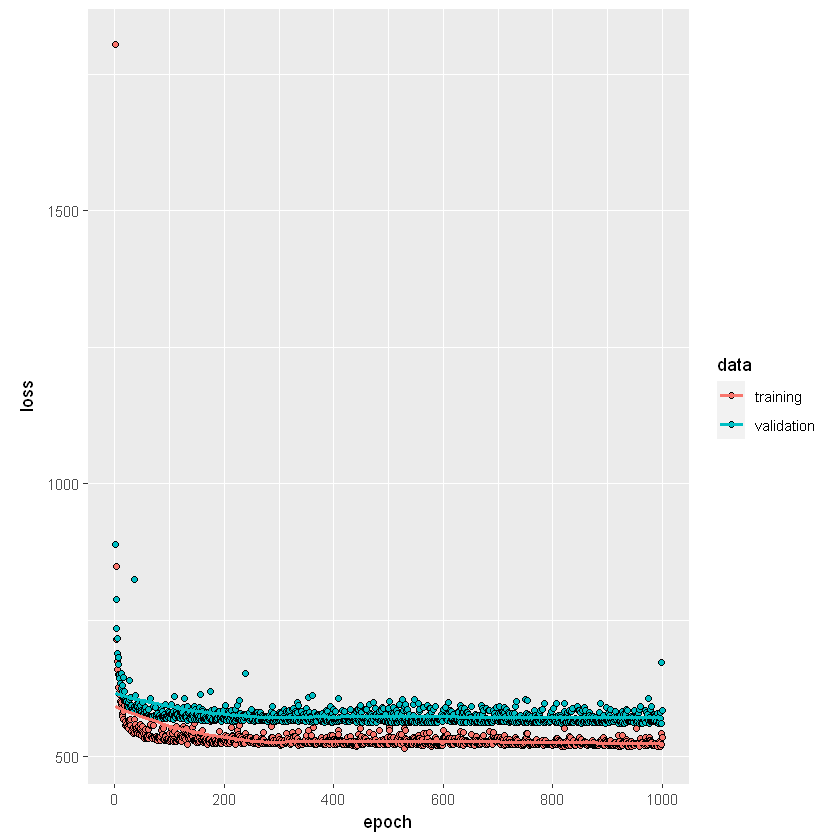

In [21]:
nn2 <- keras_model_sequential()
nn2 %>% layer_dense(units = 3000, activation = 'sigmoid', kernel_regularizer = regularizer_l2(l = .1), input_shape = 4870) %>% 
      layer_dense(units = 1500, kernel_regularizer = regularizer_l2(l = .1), activation = 'relu') %>%
      layer_dense(units = 500, kernel_regularizer = regularizer_l2(l = .1), activation = 'sigmoid') %>% 
      layer_dense(units = 200, kernel_regularizer = regularizer_l2(l = .1), activation = 'relu') %>% 
      layer_dense(units = 100, kernel_regularizer = regularizer_l2(l = .1), activation = 'relu') %>% 
      layer_dense(units = 50, kernel_regularizer = regularizer_l2(l = .1), activation = 'relu') %>% 
      layer_dense(units = 1, kernel_regularizer = regularizer_l2(l = .02), activation = 'linear')

                    
nn2 %>% compile(loss = 'mse', optimizer = 'adam')
                    

history <- nn2 %>% fit(
  (X), Y, 
  epochs = 1000, 
  validation_split = 0.5
)
plot(history)

We can imagine that the data has a sort of organization but as there are 4k predictors, we will try to learn them.

## Convutionnal NN

In [3]:
X.conv <- as.matrix(X)
dim(X.conv)

[1]  708 4870

In [4]:
#reshape data
X.conv <- array_reshape(X.conv, c(nrow(X), 487, 10, 1)) #random shape


In [16]:
conv.nn <- keras_model_sequential()
conv.nn %>%
  layer_conv_2d(200,                         
                kernel_size = c(10, 5),     
                strides = c(2, 1),           
                activation = 'relu',
                input_shape = c(487, 10, 1)) %>%
  layer_conv_2d(100,                         
                kernel_size = c(4, 4),     
                strides = c(1, 1),           
                activation = 'relu') %>%
  layer_conv_2d(50,                         
                kernel_size = c(2, 1),     
                strides = c(1, 1),           
                activation = 'relu') %>%
  layer_flatten() %>%                        
  layer_dense(units = 400, activation = 'relu') %>%
  layer_dense(units = 1, activation = 'relu')

In [17]:
conv.nn %>% compile(
  loss = 'mse',
  optimizer = 'adam',
)


`geom_smooth()` using formula 'y ~ x'


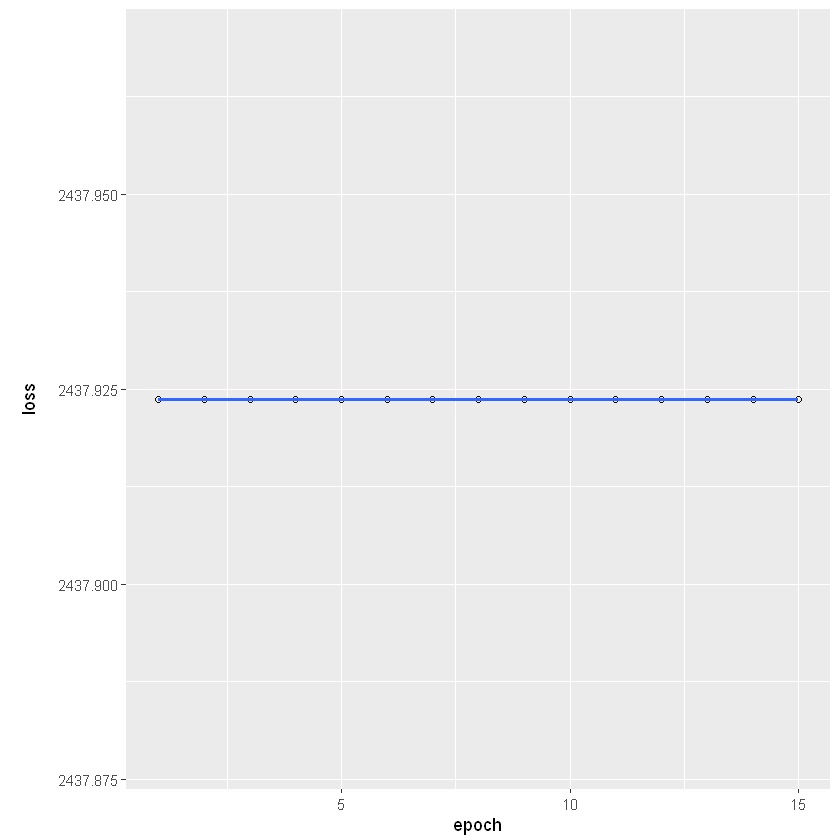

In [19]:
history <- conv.nn %>% fit(
  X.conv, Y,
  epochs = 15,
  #callbacks = callback_early_stopping(monitor = "val_loss")
)
plot(history)